In [11]:
import Makie
import CairoMakie
using ZebrafishHMM2023: normalize_all!, load_behaviour_free_swimming_trajs,
    ZebrafishHMM_G4, markov_equilibrium, stubborness_factor
using HiddenMarkovModels: baum_welch, viterbi
using Statistics: mean, std
using Distributions: Normal, Gamma, fit_mle
using LinearAlgebra: eigen

In [2]:
trajs = load_behaviour_free_swimming_trajs(18);

In [8]:
fit_mle(Gamma, +filter(>(0), reduce(vcat, trajs)))

Gamma{Float64}(α=0.6174373575550176, θ=15.396806238735984)

In [9]:
fit_mle(Gamma, -filter(<(0), reduce(vcat, trajs)))

Gamma{Float64}(α=0.6112468205330461, θ=15.695592378162841)

In [10]:
hmm = ZebrafishHMM_G4(
    rand(4),
    rand(4,4),
    Normal(0, 3),
    Gamma(0.5, 20)
)
normalize_all!(hmm)
(hmm, lL) = baum_welch(hmm, trajs, length(trajs); max_iterations = 100);

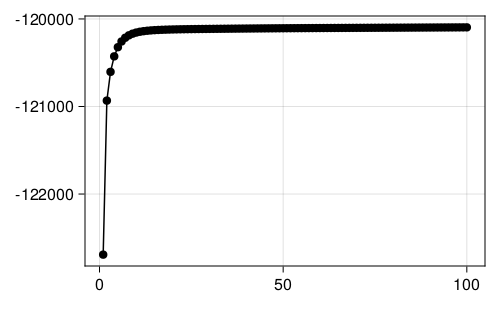

In [12]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=400, height=250)
Makie.scatterlines!(ax, lL, color=:black)
Makie.resize_to_layout!(fig)
fig

In [15]:
sim_trajs = [rand(hmm, length(t)) for t = trajs];

In [25]:
function stubborn_segments(state_seq::AbstractVector{Int})
    L = findall(==(3), state_seq)
    R = findall(==(4), state_seq)

    L_to_L = Tuple{Int,Int}[]
    R_to_R = Tuple{Int,Int}[]
    L_to_R = Tuple{Int,Int}[]
    R_to_L = Tuple{Int,Int}[]

    for i = eachindex(state_seq), j = eachindex(state_seq)
        if i < j && all(∈((1,2)), state_seq[i + 1:j - 1])
            if state_seq[i] == state_seq[j] == 3
                push!(L_to_L, (i, j))
            elseif state_seq[i] == state_seq[j] == 4
                push!(R_to_R, (i, j))
            elseif state_seq[i] == 3 && state_seq[j] == 4
                push!(L_to_R, (i, j))
            elseif state_seq[i] == 4 && state_seq[j] == L
                push!(R_to_L, (i, j))
            end
        end
    end

    return (; L_to_L, R_to_R, L_to_R, R_to_L)
end

stubborn_segments (generic function with 2 methods)

In [29]:
segments = [stubborn_segments(t.state_seq) for t = sim_trajs];

In [34]:
all_L_to_L = reduce(vcat, s.L_to_L for s = segments);
all_R_to_R = reduce(vcat, s.R_to_R for s = segments);
all_L_to_R = reduce(vcat, s.L_to_R for s = segments);
all_L_to_R = reduce(vcat, s.L_to_R for s = segments);